This notebook implements a condensed Julia version of this [Python-Based Hungarian Algorithm Jupyter Notebook](https://github.com/jbrightuniverse/Hungarian-Algorithm-No.-5/blob/main/HungarianAlgorithm.ipynb) and illustrates the procedures used in the readings on the Hungarian Algorithm. These original readings can be found at [https://montoya.econ.ubc.ca/Econ514/hungarian.pdf](https://montoya.econ.ubc.ca/Econ514/hungarian.pdf). The code is derived from [the algorithm as included in this repo](https://github.com/jbrightuniverse/hungarianalg-julia), with rendering code from [https://stackoverflow.com/a/32108899](https://stackoverflow.com/a/32108899) and [this rendering engine](https://github.com/jbrightuniverse/hungarianviz).

We are most interested in finding the potentials of a particular optimal matching scenario. As in the reading, these are weights which enable us to determine what the matching is, as well as compute various equilibria in a gallery of problems. To start, we need a matrix of "revenues" to work with, which we'll take directly from the notes.

The following code retrieves a remotely-stored piece of Python for creating visual representations of stages of the algorithm and can be ignored. For those interested, this uses PyCall to allow Julia to harness image-rendering code from the Pillow Python imaging library, which lets us display fancy images of our matrices. After rendering a matrix, we save it to a virtual file for display.

In [1]:
using PyCall

pushfirst!(PyVector(pyimport("sys")."path"), "")

py"""

import os
os.system("pip install requests")

import requests
res = requests.get("https://raw.githubusercontent.com/jbrightuniverse/hungarianalg-julia/main/docs/auxiliary.py")
with open("auxiliary.py", "w") as f:
    f.write(res.content.decode("utf-8"))

from auxiliary import *

"""

You should consider upgrading via the 'c:\users\jbrig\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\jbrig\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\jbrig\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


Given this, we can generate a matrix and display it.

PyObject <IPython.core.display.HTML object>
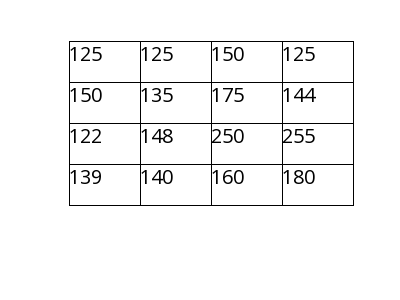

In [2]:
@pyimport IPython.display as disp

problem_array = [
    [125 125 150 125]
    [150 135 175 144]
    [122 148 250 255]
    [139 140 160 180]
]

disp.HTML(py"baserender"(problem_array, ["", "", "", ""], ["", "", "", ""]))

This is our starting array, which we entered as a list of lists. 

To find the values of the potentials at optimality, we first need to set some initial values. We start with zeroes for the column potentials, and we take the maximum entry of each row for the row potentials.

PyObject <IPython.core.display.HTML object>
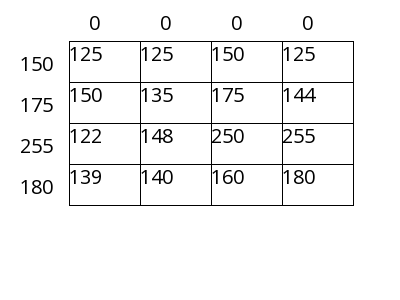

In [3]:
# IMPORTANT: Julia is one-indexed whereas Python is zero-indexed in terms of lists
matchsize = size(problem_array)[1] 

rpotentials = []
cpotentials = []
for i = 1:matchsize
    # the row weight is the maximum value in a row
    push!(rpotentials, maximum(problem_array[i,:]))
    push!(cpotentials, 0)
end

disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials))

Notice that we can take the sum of a particular row and column potential, which gives us a value. Most interesting are the results when this sum is equal to the cell associated with the particular row, column pair. Recall when we have a cell with this equality, we call it a member of the **equality graph** as in the reading. 

PyObject <IPython.core.display.HTML object>
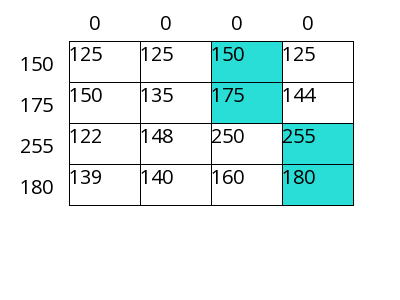

In [4]:
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true))

At the moment, since we picked the maximum value in each row to be the row potential, and since the column potentials are all zero, the highlighted cells are those which happen to have the maximal value in their respective rows.

In order to construct a matching, we need to select cells that are in the equality graph. However, we need a matching where each worker and firm is matched uniquely, so just taking the above four cells will not work. The potentials resolve this conflict by revealing cells that could *potentially* be added to our matching by conducting slight deviations from our initial state of potentials.

When we update these potentials, we need to keep track of what we already have matched. As in the notes, we have an **alternating path** which records the cells we've found prior to such an update step. This ensures that, if we do change the potentials, we don't accidentally kick out any matches we already found.

We construct this path in code as a list of "parents" of rows and columns. For example, in an alternating path we may have a row that precedes a column, or a column that precedes a row. We store the path in terms of these "parents", allowing us to traverse them backwards. This will come in handy later.

In [5]:
x_parents =  -1 * ones(Int64, 1, matchsize)
y_parents =  -1 * ones(Int64, 1, matchsize)

1×4 Matrix{Int64}:
 -1  -1  -1  -1

x here represents rows, and y represents columns.

Right now we have no paths, so all the parents are set to default values of -1. Note that its possible to have an entry on the path with no parent: the first entry. Because of this, we need some indicator that a row or column is on the path, so we can create sets that represent this.

In [6]:
path_x = BitSet([1])
nonpath_y = BitSet(1:matchsize)
path_y = BitSet()

BitSet([])

Notice that we've put a 1 in the set of rows. When we're looking for equality graph cells to put on our matching, we need to start somewhere, so we arbitrarily choose the first row as our starting point for an alternating path.

Also notice we don't have a nonpath_x. This was an intentional design choice, as it turns out we never need it.

To recap, our matrix now looks like this (with a bit of help from a pathmaking function):

PyObject <IPython.core.display.HTML object>
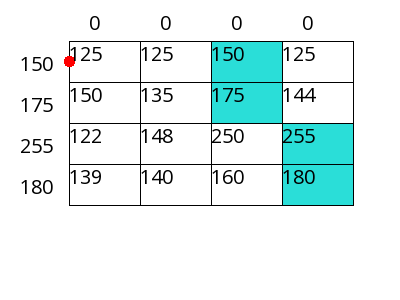

In [7]:
function make_paths(x_parents, y_parents, path_x)
    # This function can be ignored, it simply preps the paths for rendering
    list_of_paths = []
    for i in path_x
        single_path = []
        is_x = 1
        current_entry = i
        while true
            push!(single_path, current_entry - 1) # IMPORTANT: the -1 converts to zero-indexing to allow the Python rendering code to work (now the note from before becomes important!)
            if is_x == 1
                current_entry = x_parents[current_entry]
            else
                current_entry = y_parents[current_entry]
            end
            if current_entry == -1
                break
            end
            is_x = 1 - is_x
        end
        push!(list_of_paths, single_path)
    end
    return list_of_paths
end

disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true, paths = make_paths(x_parents, y_parents, path_x)))

Now we can get going. We first check to see if, given our first row, there is some column where the row-column pair's cell is in the equality graph. From inspection, we can see the blue shaded 150 is one of these because 150 + 0 = 150, but computationally we can do this as follows:

In [8]:
function find_neighbour(path_x, nonpath_y, arr, rpot, cpot)
    pair = nothing
    for x in path_x, y in nonpath_y
        if arr[x, y] == rpot[x] + cpot[y]
            pair = [x, y]
            break
        end
    end
    return pair
end

pair = find_neighbour(path_x, nonpath_y, problem_array, rpotentials, cpotentials)

2-element Vector{Int64}:
 1
 3

This dual-for loop iterates over every row we have on our path, and every column that we don't. The idea is that we have a row right now, but we don't have a column attached to it, so we wish to find one.

If we find a column where the row-column pair is an equality graph entry, we retrieve that pair, and we break off. The code successfully selected row 1, column 3, which is the blue shaded 150. We can now indicate this operation on the matrix as follows:

PyObject <IPython.core.display.HTML object>
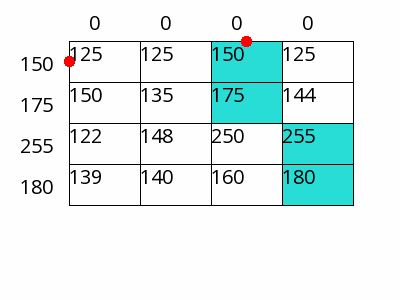

In [9]:
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true, paths = make_paths(x_parents, y_parents, path_x), terminus = [p - 1 for p in pair]))

Note we placed a red dot on the column. This is because this column has not been matched with a row before, so the column is free to be matched with this row. The pair of red dots on the outsides of the matrix form a new match that we can add to our set of matchings.

Recall that when we have this red dot on a free column at the end of our alternating path, we have constructed an **augmenting path**, and can use this to add a new match to our set of matches.

PyObject <IPython.core.display.HTML object>
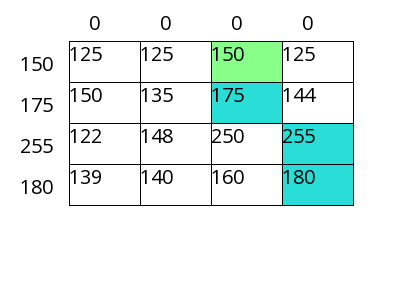

In [10]:
matching = -1 * ones(Int64, 1, matchsize)
matching[pair[1]] = pair[2]

function to_zero(match)
    return [[i - 1, match[i]-1] for i in 1:matchsize if match[i] != -1]
end

disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true, matching = to_zero(matching)))

The green cells will indicate our current "partial matching", as described in the reading. We will only be finished once every row and every column has one of these green cells, so we continue by picking the next free row (that is, a row with no green cell). Computationally, this looks like:

PyObject <IPython.core.display.HTML object>
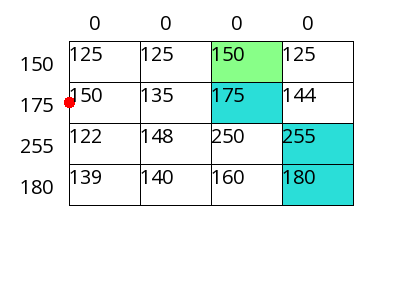

In [11]:
free = findfirst(isequal(-1), matching)[2] # selecting the next index of a -1 (unmatched row) in the matching array

# we reset our alternating paths
x_parents =  -1 * ones(Int64, 1, matchsize)
y_parents =  -1 * ones(Int64, 1, matchsize)
path_x = BitSet([free])
nonpath_y = BitSet(1:matchsize)
path_y = BitSet()
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true, paths = make_paths(x_parents, y_parents, path_x), matching = to_zero(matching)))

We now continue as we did before. We look for a new free column to add:

In [12]:
pair = find_neighbour(path_x, nonpath_y, problem_array, rpotentials, cpotentials)

2-element Vector{Int64}:
 2
 3

In [13]:
pair[2] in matching

true

Here we have an issue. Column 3, which we found was in the equality graph (or a "neighbour") with row 2, is already matched with row 1. This is where the alternating path becomes useful, as we will record this conflict and look for another free column.

PyObject <IPython.core.display.HTML object>
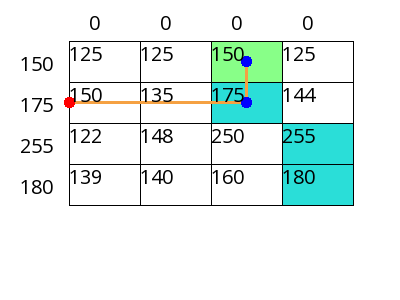

In [14]:
wasMatchedTo = findfirst(isequal(pair[2]), matching)[2] # find the row it was matched to

# add matched row and matched column to path along with the unmatched row: the path now looks like unmatched row -> matched column -> matched row
push!(path_x, wasMatchedTo)
push!(path_y, pair[2])
delete!(nonpath_y, pair[2])
y_parents[pair[2]] = pair[1]
x_parents[wasMatchedTo] = pair[2]
savestr = py"baserender"(problem_array, rpotentials, cpotentials, equality = true, paths = make_paths(x_parents, y_parents, path_x), matching = to_zero(matching))
disp.HTML(savestr)

Now we look for neighbours again:

In [15]:
pair = find_neighbour(path_x, nonpath_y, problem_array, rpotentials, cpotentials)
println(pair)

nothing


Since we have nothing, there is no neighbour. We finally get to use the potentials, which will allow us to create a new neighbour.

As in the notes, we iterate over every row on our path, and every free column (that is, not on the path), and compute the difference between the sum of the potentials and the value in the cell. The cell where the difference is smallest is the one we are looking for. Mathematically:

$$\min_{x \in path\_x, y \in nonpath\_y} \lambda(x) + \lambda(y) - v(x, y)$$

where $\lambda$ represents potential and $v$ represents cell value. Computationally, we do the following:

In [16]:
function update_potentials(rpotentials, cpotentials, matrx)
    big = Inf
    pair = nothing
    # iterate over relevant pairs
    for dx in path_x, dy in nonpath_y
        # find the difference and check if its smaller than any we found before
        alpha = rpotentials[dx] + cpotentials[dy] - matrx[dx, dy]
        if alpha < big
          big = alpha
          pair = [dx, dy]
        end
    end

    # apply difference to potentials as needed
    for dx in path_x 
        rpotentials[dx] -= big
    end

    for dy in path_y
        cpotentials[dy] += big
    end
    return pair
end

println(rpotentials, " ", cpotentials)
pair = update_potentials(rpotentials, cpotentials, problem_array)
println(rpotentials, " ", cpotentials)
println(pair)

Any[150, 175, 255, 180] Any[0, 0, 0, 0]
Any[125, 150, 255, 180] Any[0, 0, 25, 0]
[1, 1]


PyObject <IPython.core.display.HTML object>
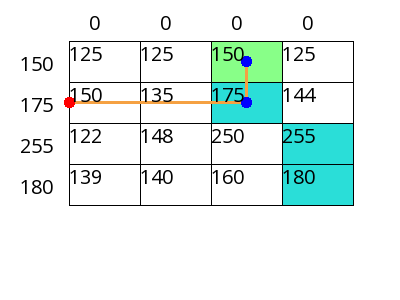

In [17]:
disp.HTML(savestr)

PyObject <IPython.core.display.HTML object>
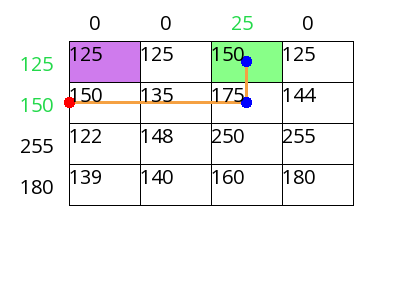

In [18]:
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = false, 
                            paths = make_paths(x_parents, y_parents, path_x), matching = to_zero(matching), highlight = [[i-1 for i in path_x], [i-1 for i in path_y]], hpath = [i-1 for i in pair]))

Compare the original matrix setup to the new one. The purple shaded cell was computed to be the cell of smallest difference between value and potentials, across the rows that are on the path and the columns that are not on the path. Observe that row 1 lies on our path, and column 1 does not. (The path can be broken down by observing the blue circles).

Given that this is the cell of smallest difference, it is therefore the one which would have the least impact on our potentials should we want to modify them to add this cell to the equality graph. We then use the difference between the potentials and the cell value to modify these potentials. The difference is subtracted from the row potentials of rows that are on the path, and added to the column potentials of columns that are on the path. This reweighting adds the new cell to the equality graph while ensuring all our existing cells are maintained as well. Observe now that the equality graph looks like:

PyObject <IPython.core.display.HTML object>
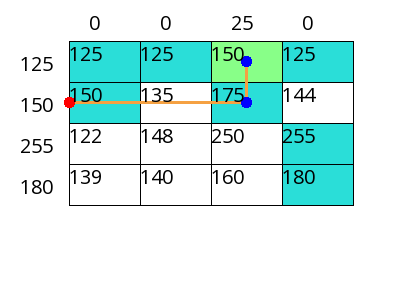

In [19]:
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true, paths = make_paths(x_parents, y_parents, path_x), matching = to_zero(matching)))

Many additional cells were added as a side effect of our operations, but the cell we targeted by identifying the least difference is indeed a part of the equality graph now. We can run the neighbours function again to obtain it. 

In [20]:
pair = find_neighbour(path_x, nonpath_y, problem_array, rpotentials, cpotentials)

2-element Vector{Int64}:
 1
 1

In [21]:
pair[2] in matching

false

Clearly this new cell is not matched to anything, so we can add it.

PyObject <IPython.core.display.HTML object>
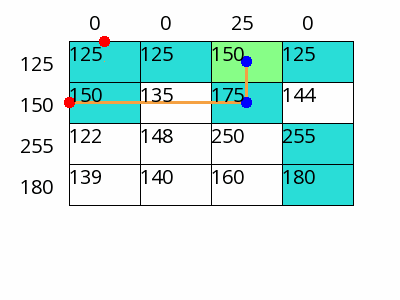

In [22]:
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true, paths = make_paths(x_parents, y_parents, path_x), matching = to_zero(matching), terminus = [p - 1 for p in pair]))

As in the readings, the alternating path is a collection of cells in the equality graph. That is, if we wanted to, we could include them in our matching, but not all of them are included due to conflicts between shared rows or columns.

If you take a look at the path above, it also "alternates" between an unmatched cell, matched cell, and another unmatched cell. Since we have constructed an augmenting path to a free column, what we can actually do is conduct a "swap" of the cells that we have matched. Our free column, column 1, can be swapped with column 3 in terms of being matched to row 1, for example. At the same time, we can assign column 3 to be matched with our original free row 2, since it is on the path as well. Computationally, we have:

PyObject <IPython.core.display.HTML object>
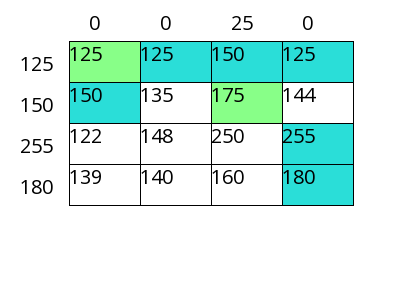

In [23]:
matching[pair[1]] = pair[2]
source = pair[1]
matched = 1
while true
    if matched == 1
        if x_parents[source] == -1
            break
        end
        above = x_parents[source]
    else
        above = y_parents[source]
        matching[above] = source
    end
    matched = 1 - matched
    source = above
end

disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true, matching = to_zero(matching)))

Essentially we have inverted each cell state along our alternating path. Cells in the match were removed, and cells not in the match were added to the match. Because the cells on the ends of the path were not included in the matching, this expands the size of the matching by one.

Finally, we repeat the above process until we have a full four matched cells. This composes the algorithm.

In [24]:
free = findfirst(isequal(-1), matching)[2] 
x_parents =  -1 * ones(Int64, 1, matchsize)
y_parents =  -1 * ones(Int64, 1, matchsize)
path_x = BitSet([free])
nonpath_y = BitSet(1:matchsize)
path_y = BitSet()

pair = find_neighbour(path_x, nonpath_y, problem_array, rpotentials, cpotentials)

2-element Vector{Int64}:
 3
 4

In [25]:
pair[2] in matching

false

The neighbouring column we just found wasn't matched, so we can add it as follows:

PyObject <IPython.core.display.HTML object>
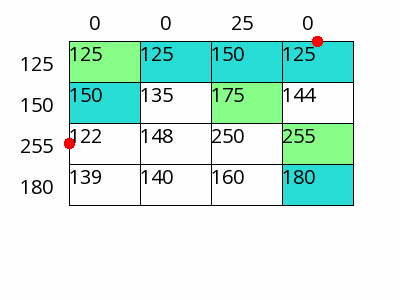

In [26]:
matching[pair[1]] = pair[2]
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true, paths = make_paths(x_parents, y_parents, path_x), matching = to_zero(matching), terminus = [p - 1 for p in pair]))

In [27]:
free = findfirst(isequal(-1), matching)[2] 
x_parents =  -1 * ones(Int64, 1, matchsize)
y_parents =  -1 * ones(Int64, 1, matchsize)
path_x = BitSet([free])
nonpath_y = BitSet(1:matchsize)
path_y = BitSet()

pair = find_neighbour(path_x, nonpath_y, problem_array, rpotentials, cpotentials)

2-element Vector{Int64}:
 4
 4

PyObject <IPython.core.display.HTML object>
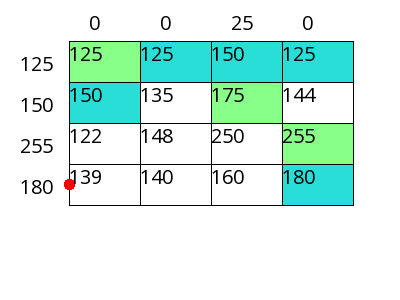

In [28]:
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true, paths = make_paths(x_parents, y_parents, path_x), matching = to_zero(matching)))

We are now attempting to find a match for the 4th row, as indicated by the red dot.

In [29]:
pair[2] in matching

true

This column was matched before, so we expand our alternating path to include it.

PyObject <IPython.core.display.HTML object>
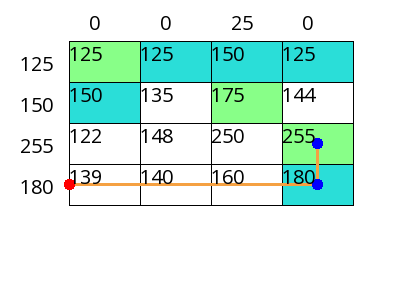

In [30]:
wasMatchedTo = findfirst(isequal(pair[2]), matching)[2]

push!(path_x, wasMatchedTo)
push!(path_y, pair[2])
delete!(nonpath_y, pair[2])
y_parents[pair[2]] = pair[1]
x_parents[wasMatchedTo] = pair[2]
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true, paths = make_paths(x_parents, y_parents, path_x), matching = to_zero(matching)))

In [31]:
pair = find_neighbour(path_x, nonpath_y, problem_array, rpotentials, cpotentials)
println(pair)

nothing


There are no more neighbours we could try to look for, so we must update the potentials a second time. We look at rows 3 and 4, since they are on our path, and we look at columns 1, 2 and 3, since they are not on our path. Somewhere along here, the difference between the sum of the potentials and the value in their corresponding cell is the minimum across all candidates, and we will use this difference to adjust the potentials to include this cell in the equality graph.

PyObject <IPython.core.display.HTML object>
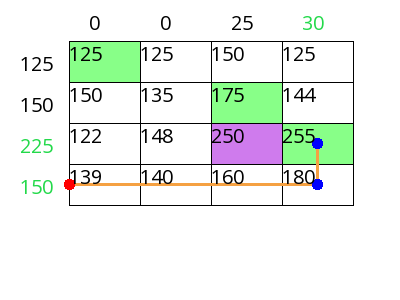

In [32]:
pair = update_potentials(rpotentials, cpotentials, problem_array)
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = false, 
                            paths = make_paths(x_parents, y_parents, path_x), matching = to_zero(matching), highlight = [[i-1 for i in path_x], [i-1 for i in path_y]], hpath = [i-1 for i in pair]))

Now that we found this cell of minimum difference, and updated the potentials along our path, we can use it to expand our path. Observe the equality graph now looks like:

[3, 3]


PyObject <IPython.core.display.HTML object>
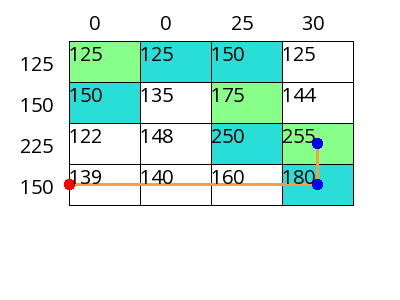

In [33]:
pair = find_neighbour(path_x, nonpath_y, problem_array, rpotentials, cpotentials)
println(pair)
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true, paths = make_paths(x_parents, y_parents, path_x), matching = to_zero(matching)))

In [34]:
pair[2] in matching

true

It turns out the column we added through reweighting the potentials was already matched, so we expand our path and keep going.

PyObject <IPython.core.display.HTML object>
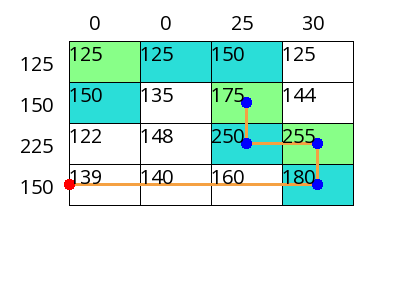

In [35]:
wasMatchedTo = findfirst(isequal(pair[2]), matching)[2] # find the row it was matched to

push!(path_x, wasMatchedTo)
push!(path_y, pair[2])
delete!(nonpath_y, pair[2])
y_parents[pair[2]] = pair[1]
x_parents[wasMatchedTo] = pair[2]
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true, paths = make_paths(x_parents, y_parents, path_x), matching = to_zero(matching)))

In [36]:
pair = find_neighbour(path_x, nonpath_y, problem_array, rpotentials, cpotentials)
println(pair)
pair[2] in matching

[2, 1]


true

We've found another neighbour to our path, but it was also previously matched, so we expand the path again.

PyObject <IPython.core.display.HTML object>
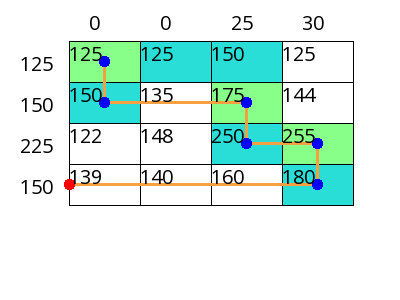

In [37]:
wasMatchedTo = findfirst(isequal(pair[2]), matching)[2]

push!(path_x, wasMatchedTo)
push!(path_y, pair[2])
delete!(nonpath_y, pair[2])
y_parents[pair[2]] = pair[1]
x_parents[wasMatchedTo] = pair[2]
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true, paths = make_paths(x_parents, y_parents, path_x), matching = to_zero(matching)))

In [38]:
pair = find_neighbour(path_x, nonpath_y, problem_array, rpotentials, cpotentials)
println(pair)
pair[2] in matching

[1, 2]


false

We've finally found a neighbour in a free (unmatched) column, so we expand our path to it to complete an augmenting path.

PyObject <IPython.core.display.HTML object>
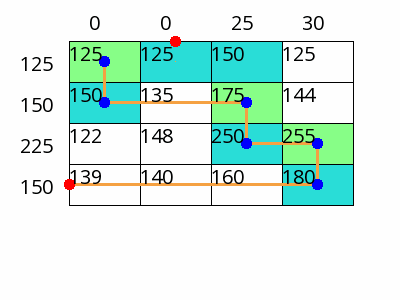

In [39]:
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = true, paths = make_paths(x_parents, y_parents, path_x), matching = to_zero(matching), terminus = [p - 1 for p in pair]))

This enables us to run the match-inversion procedure, which flips the state of all cells on the path and expands the size of our matching by one entry.

PyObject <IPython.core.display.HTML object>
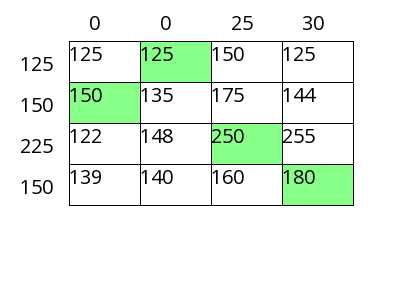

In [40]:
matching[pair[1]] = pair[2]
source = pair[1]
matched = 1
while true
    if matched == 1
        if x_parents[source] == -1
            break
        end
        above = x_parents[source]
    else
        above = y_parents[source]
        matching[above] = source
    end
    matched = 1 - matched
    source = above
end

disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = false, matching = to_zero(matching)))

With four matches, we are finished. Observe that if you add up the potentials for each cell, they will all be equal to the cell values. The inclusion of these cells in the optimal matching was the result of the slight adjustments to the potentials we conducted as the algorithm progressed. The potentials surrounding the above matrix are the potentials at optimality, which as in the reading constitute an equilibrium in a matching game between the rows and columns.

The procedure for the algorithm above involved a lot of copying and pasting. We can condense everything we did into a much simpler program by using a loop, which is what was done to create this library: [https://github.com/jbrightuniverse/hungarianalg-julia/blob/main/src/HungarianAlg.jl](https://github.com/jbrightuniverse/hungarianalg-julia/blob/main/src/HungarianAlg.jl). We can run it within this notebook to compare.

In [41]:
using Pkg
Pkg.add(PackageSpec(url="https://github.com/jbrightuniverse/hungarianalg-julia/"))

In [42]:
using HungarianAlg: hungarian, display
result = hungarian(problem_array)
println(display(result))

Matching:
["   ", "125", "   ", "   "]
["150", "   ", "   ", "   "]
["   ", "   ", "250", "   "]
["   ", "   ", "   ", "180"]

Row Potentials: Any[125, 150, 225, 150]
Column Potentials: Any[0, 0, 25, 30]


Indeed, this is the exact same result, albeit achieved much faster by encapsulating all the methods into a single loop. The individual rendering frames can also be obtained by using a [particular Python version of this algorithm](https://github.com/jbrightuniverse/hungarianviz) as follows:

In [43]:
py"""

import os
os.system("pip install git+https://github.com/jbrightuniverse/hungarianviz")

from hungarianviz.alg import hungarian

def process(arr):
    result = hungarian(arr)
    print(result)

"""

py"process"(problem_array)

  Cloning https://github.com/jbrightuniverse/hungarianviz to c:\users\jbrig\appdata\local\temp\pip-req-build-qjqcj97s
Using legacy setup.py install for hungarianviz, since package 'wheel' is not installed.
Matching:
['   ', '125', '   ', '   ']
['150', '   ', '   ', '   ']
['   ', '   ', '250', '   ']
['   ', '   ', '   ', '180']

Row Potentials: [125, 150, 225, 150]
Column Potentials: [0, 0, 25, 30]


  Running command git clone -q https://github.com/jbrightuniverse/hungarianviz 'C:\Users\jbrig\AppData\Local\Temp\pip-req-build-qjqcj97s'
You should consider upgrading via the 'c:\users\jbrig\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


Again, we get the same result, and the frames can be obtained as follows:

PyObject <IPython.core.display.HTML object>
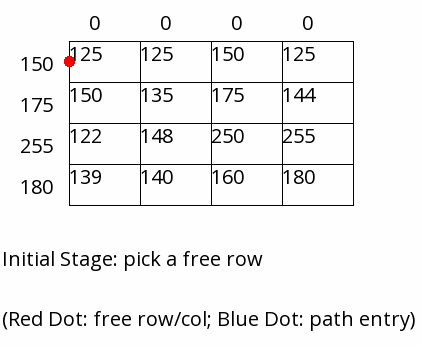

In [44]:
py"""

def get_frames(arr):
    result = hungarian(arr)
    filex = BytesIO()
    result.frames[0].save(fp=filex, format='GIF', append_images=result.frames[1:], save_all=True, duration=4000, loop=0)
    return "<img src='data:image/gif;base64,{0}'/>".format(b64encode(filex.getvalue()).decode('utf-8'))

"""

disp.HTML(py"get_frames"(problem_array))

As reference, our final result from the notebook was:

PyObject <IPython.core.display.HTML object>
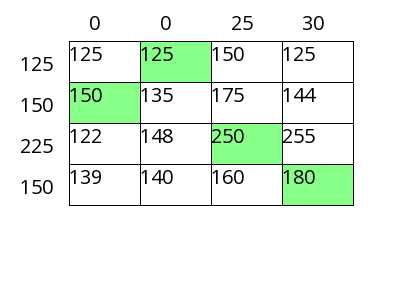

In [45]:
disp.HTML(py"baserender"(problem_array, rpotentials, cpotentials, equality = false, matching = to_zero(matching)))

which is exactly the same result, and the same as in the reading.